# Testing
In this final tutorial we load the weights we trained in the previous tutorial into a static version of the mushroom body model and evaluate its performance on the MNIST test set.

## Install PyGeNN wheel from Google Drive
Download wheel file

In [1]:
if "google.colab" in str(get_ipython()):
    #import IPython
    #IPython.core.magics.execution.ExecutionMagics.run.func_defaults[2] = lambda a: a
    #%run "../install_collab.ipynb"
    !pip install gdown --upgrade
    !gdown 1V_GzXUDzcFz9QDIpxAD8QNEglcSipssW
    !pip install pygenn-5.0.0-cp310-cp310-linux_x86_64.whl
    %env CUDA_PATH=/usr/local/cuda

Downloading...
From: https://drive.google.com/uc?id=1V_GzXUDzcFz9QDIpxAD8QNEglcSipssW
To: /content/pygenn-5.0.0-cp310-cp310-linux_x86_64.whl
100% 8.38M/8.38M [00:00<00:00, 187MB/s]
Processing ./pygenn-5.0.0-cp310-cp310-linux_x86_64.whl
pygenn is already installed with the same version as the provided wheel. Use --force-reinstall to force an installation of the wheel.
env: CUDA_PATH=/usr/local/cuda


## Install MNIST package

In [2]:
!pip install mnist

## Build tutorial model
Import modules

In [3]:
import mnist
import numpy as np
from copy import copy
from google.colab import drive
from matplotlib import pyplot as plt
from pygenn import (create_current_source_model, create_neuron_model, init_postsynaptic,
                    init_sparse_connectivity, init_weight_update, GeNNModel)
from tqdm.auto import tqdm

In [4]:
# Reshape and normalise training data
mnist.datasets_url = "https://storage.googleapis.com/cvdf-datasets/mnist/"
testing_images = mnist.test_images()
testing_images = np.reshape(testing_images, (testing_images.shape[0], -1)).astype(np.float32)
testing_images /= np.sum(testing_images, axis=1)[:, np.newaxis]
testing_labels = mnist.test_labels()

In [5]:
from google.colab import drive
drive.mount("/content/drive")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
pn_kc_ind = np.load("/content/drive/MyDrive/pn_kc_ind.npy")
kc_mbon_g = np.load("/content/drive/MyDrive/kc_mbon_g.npy")

## Parameters
Define some model parameters

In [7]:
# Simulation time step
DT = 0.1

# Scaling factor for converting normalised image pixels to input currents (nA)
INPUT_SCALE = 80.0

# Number of Projection Neurons in model (should match image size)
NUM_PN = 784

# Number of Kenyon Cells in model (defines memory capacity)
NUM_KC = 20000

# Number of Mushroom Body Output Neurons (should match number of labels)
NUM_MBON = 10

# How long to present each image to model
PRESENT_TIME_MS = 20.0

# Standard LIF neurons parameters
LIF_PARAMS = {
    "C": 0.2,
    "TauM": 20.0,
    "Vrest": -60.0,
    "Vreset": -60.0,
    "Vthresh": -50.0,
    "Ioffset": 0.0,
    "TauRefrac": 2.0}

# We only want PNs to spike once
PN_PARAMS = copy(LIF_PARAMS)
PN_PARAMS["TauRefrac"] = 100.0

# Weight of each synaptic connection
PN_KC_WEIGHT = 0.2

# Time constant of synaptic integration
PN_KC_TAU_SYN = 3.0

# How many projection neurons should be connected to each Kenyon Cell
PN_KC_FAN_IN = 20

# Time constant of synaptic integration
KC_MBON_TAU_SYN = 3.0

# We will use weights of 1.0 for KC->GGN connections and
# want the GGN to inhibit the KCs after 200 spikes
GGN_PARAMS = {
    "Vthresh": 200.0}

## Custom models
As well as the models we defined before:

In [8]:
# Current source model, allowing current to be injected into neuron from variable
cs_model = create_current_source_model(
    "cs_model",
    vars=[("magnitude", "scalar")],
    injection_code="injectCurrent(magnitude);")

# Minimal integrate and fire neuron model
if_model = create_neuron_model(
    "IF",
    params=["Vthresh"],
    vars=[("V", "scalar")],
    sim_code=
    """
    V += Isyn;
    """,
    threshold_condition_code=
    """
    V >= Vthresh
    """,
    reset_code=
    """
    V = 0.0;
    """)

## Model definition
Create a new model called "mnist_mb_second_layer_gain_control" as before although we no longer need to record spikes from individual neurons:

In [9]:
# Create model
model = GeNNModel("float", "mnist_mb_testing")
model.dT = DT

# Create neuron populations
lif_init = {"V": PN_PARAMS["Vreset"], "RefracTime": 0.0}
if_init = {"V": 0.0}
pn = model.add_neuron_population("pn", NUM_PN, "LIF", PN_PARAMS, lif_init)
kc = model.add_neuron_population("kc", NUM_KC, "LIF", LIF_PARAMS, lif_init)
ggn = model.add_neuron_population("ggn", 1, if_model, GGN_PARAMS, if_init)
mbon = model.add_neuron_population("mbon", NUM_MBON, "LIF", LIF_PARAMS, lif_init)

# Turn on spike recording
pn.spike_recording_enabled = True
kc.spike_recording_enabled = True
mbon.spike_recording_enabled = True

# Create current sources to deliver input to network
pn_input = model.add_current_source("pn_input", cs_model, pn , {}, {"magnitude": 0.0})

# Create synapse populations
kc_ggn = model.add_synapse_population("kc_ggn", "DENSE",
                                      kc, ggn,
                                      init_weight_update("StaticPulseConstantWeight", {"g": 1.0}),
                                      init_postsynaptic("DeltaCurr"))

ggn_kc = model.add_synapse_population("ggn_kc", "DENSE",
                                      ggn, kc,
                                      init_weight_update("StaticPulseConstantWeight", {"g": -5.0}),
                                      init_postsynaptic("ExpCurr", {"tau": 5.0}))



/usr/local/lib/python3.10/dist-packages/pygenn/_deprecated.py:14: FutureWarning: Call to deprecated function dT. (The name of this property was inconsistent, use dt instead) -- Deprecated since version 4.9.0
  warn(f"Call to deprecated function {func.__name__}."


In [10]:
pn_kc = model.add_synapse_population("pn_kc", "SPARSE",
                                     pn, kc,
                                     init_weight_update("StaticPulseConstantWeight", {"g": PN_KC_WEIGHT}),
                                     init_postsynaptic("ExpCurr", {"tau": PN_KC_TAU_SYN}))
pn_kc.set_sparse_connections(pn_kc_ind[0], pn_kc_ind[1])

In [11]:
kc_mbon = model.add_synapse_population("kc_mbon", "DENSE",
                                       kc, mbon,
                                       init_weight_update("StaticPulse", {}, {"g": kc_mbon_g}),
                                       init_postsynaptic("ExpCurr", {"tau": KC_MBON_TAU_SYN}))

## Build model
Generate code and load it into PyGeNN (as we're no longer recording spikes, we don't need to allocate a recording buffer)

In [12]:
# Convert present time into timesteps
present_timesteps = int(round(PRESENT_TIME_MS / DT))

# Build model and load it
model.build()
model.load(num_recording_timesteps=present_timesteps)

## Simulate tutorial model
As well as resetting the state of every neuron after presenting each stimuli, because we have now added synapses with their own dynamics, these also need to be reset.
 This function resets neuron state variables selected by the keys of a dictionary to the values specifed in the dictionary values and pushes the new values to the GPU.

Now, like before, we loop through 4 stimuli and simulate the model. However, now we need to reset the Projection Neuron and Kenyon Cell populations; **and** the synapses between them. Additionally, we want to show spikes from the Kenyon Cells as well as the Projection Neurons.

In [13]:
def reset_out_post(pop):
    pop.out_post.view[:] = 0.0
    pop.out_post.push_to_device()

def reset_neuron(pop, var_init):
    # Reset variables
    for var_name, var_val in var_init.items():
        pop.vars[var_name].view[:] = var_val

        # Push the new values to GPU
        pop.vars[var_name].push_to_device()

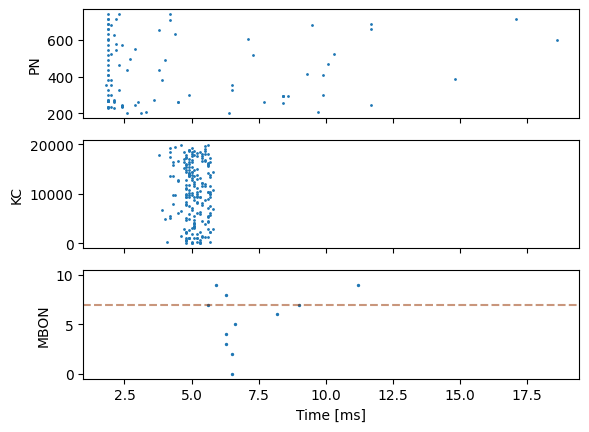

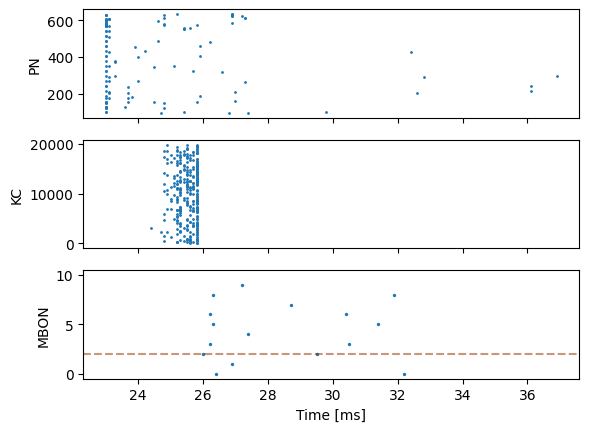

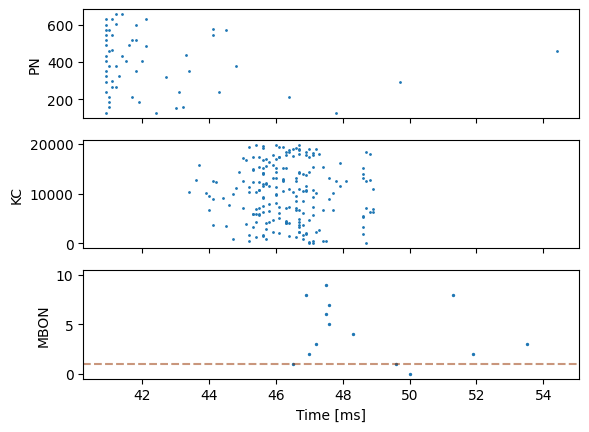

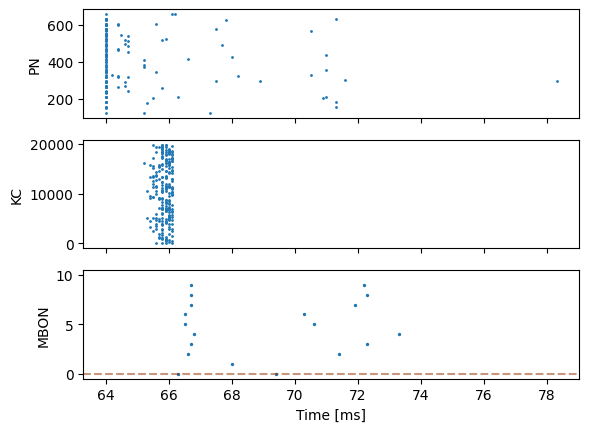

In [14]:
for s in range(4):
    # Set testing image
    pn_input.vars["magnitude"].view[:] = testing_images[s] * INPUT_SCALE
    pn_input.vars["magnitude"].push_to_device()

    # Simulate present timesteps
    for i in range(present_timesteps):
        model.step_time()

    # Reset neuron state for next stimuli
    reset_neuron(pn, lif_init)
    reset_neuron(kc, lif_init)
    reset_neuron(ggn, if_init)
    reset_neuron(mbon, lif_init)

    # Reset synapse state
    reset_out_post(pn_kc)
    reset_out_post(ggn_kc)

    # Download spikes from GPU
    model.pull_recording_buffers_from_device();

    # Plot PN, KC and MBON spikes
    fig, axes = plt.subplots(3, sharex=True)
    pn_spike_times, pn_spike_ids = pn.spike_recording_data[0]
    kc_spike_times, kc_spike_ids = kc.spike_recording_data[0]
    mbon_spike_times, mbon_spike_ids = mbon.spike_recording_data[0]


    axes[0].scatter(pn_spike_times, pn_spike_ids, s=1)
    axes[0].set_ylabel("PN")
    axes[1].scatter(kc_spike_times, kc_spike_ids, s=1)
    axes[1].set_ylabel("KC")
    axes[2].scatter(mbon_spike_times, mbon_spike_ids, s=2)
    axes[2].axhline(testing_labels[s], linestyle="--", color="green", alpha=0.3)
    axes[2].set_ylim((-0.5, 10.5))

    if len(mbon_spike_times) > 0:
        classification = mbon_spike_ids[np.argmin(mbon_spike_times)]
        axes[2].axhline(classification, linestyle="--", color="red", alpha=0.3)
    axes[2].set_ylabel("MBON")

    axes[2].set_xlabel("Time [ms]")

In [15]:
num_correct = 0
for s in tqdm(range(testing_images.shape[0])):
    # Set testing image
    pn_input.vars["magnitude"].view[:] = testing_images[s] * INPUT_SCALE
    pn_input.vars["magnitude"].push_to_device()

    # Simulate present timesteps
    for i in range(present_timesteps):
        model.step_time()

    # Reset neuron state
    reset_neuron(pn, lif_init)
    reset_neuron(kc, lif_init)
    reset_neuron(ggn, if_init)
    reset_neuron(mbon, lif_init)

    # Reset synapse state
    reset_out_post(pn_kc)
    reset_out_post(ggn_kc)
    reset_out_post(kc_mbon)

    # Download spikes from GPU
    model.pull_recording_buffers_from_device();

    # Determine the classification and count correct
    mbon_spike_times, mbon_spike_ids = mbon.spike_recording_data[0]
    if len(mbon_spike_times) > 0:
        if mbon_spike_ids[np.argmin(mbon_spike_times)] == testing_labels[s]:
            num_correct += 1

print(f"\n{num_correct}/{testing_images.shape[0]} correct ({(num_correct * 100.0) / testing_images.shape[0]} %%)")

  0%|          | 0/10000 [00:00<?, ?it/s]


8052/10000 correct (80.52 %%)
